In [1]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.interpolate import interp1d

from pyia import GaiaData

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp

In [2]:
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)
pot = gp.load('../output/mwpot.yml')

In [3]:
g = GaiaData('../data/gd1.fits')
c = g.get_skycoord(distance=False)

In [4]:
iso = Table.read('/mnt/ceph/users/apricewhelan/data/isochrones/mist/FeH_-1.5_iso.fits')
# iso = Table.read('../data/mist_12.0_-1.35.cmd', format='ascii.commented_header', header_start=12)
# iso = Table.read('../data/mist_12.6_-1.80.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<4)
iso = iso[phasecut]
iso = iso[iso['log10_isochrone_age_yr'] == 10.1]

phi1, phi2 selection window:

In [6]:
phi12_poly = np.load('../output/phi12_poly.npy')[:64]
phi12_poly[:, 1] += 1.5
phi12_poly = np.concatenate((np.array([[-90, -3.7],
                                       [-95, -4.4],
                                       [-100., -5]]), phi12_poly))

_f = interp1d(phi12_poly[:, 0], phi12_poly[:, 1], kind='cubic')
_x = np.linspace(-100, 20, 256)
track = _f(_x)
gd1_track = np.stack((_x, track)).T

# Now make a selection for the stream:
_top = gd1_track.copy()
_top[:, 1] += 1.5
_btm = gd1_track.copy()
_btm[:, 1] -= 1.5

gd1_poly = np.vstack((_top, _btm[1:][::-1]))
gd1_phi_path = mpl.path.Path(gd1_poly)

# Now make a selection off of the stream:
_top = gd1_track.copy()
_top[:, 1] += 4
_btm = gd1_track.copy()
_btm[:, 1] += 4-1.5
ctl_poly1 = np.vstack((_top, _btm[1:][::-1]))

_top = gd1_track.copy()
_top[:, 1] -= 4-1.5
_btm = gd1_track.copy()
_btm[:, 1] -= 4
ctl_poly2 = np.vstack((_top, _btm[1:][::-1]))

ctl_phi_path = [mpl.path.Path(ctl_poly1),
                mpl.path.Path(ctl_poly2)]

In [7]:
# fig, ax = plt.subplots()
# ax.add_patch(mpl.patches.Polygon(gd1_phi_path.vertices))
# ax.add_patch(mpl.patches.Polygon(ctl_phi_path[0].vertices))
# ax.add_patch(mpl.patches.Polygon(ctl_phi_path[1].vertices))

# ax.plot(c_gd1.phi1.wrap_at(180*u.deg).degree[all_cmd_mask & pm_mask],
#         c_gd1.phi2.degree[all_cmd_mask & pm_mask],
#         marker='o', ls='none')

Use Koposov's orbit fit to improve selection:

In [8]:
phi1_0 = 20. * u.deg
phi2, d, pm1, pm2, vr = [-3.47508128, 12.26167861, -5.70045271, -1.44728289, -326.96300355]
c0 = gc.GD1(phi1=phi1_0, phi2=phi2*u.deg, distance=d*u.kpc, 
            pm_phi1_cosphi2=pm1*u.mas/u.yr,
            pm_phi2=pm2*u.mas/u.yr,
            radial_velocity=vr*u.km/u.s)
w0 = gd.PhaseSpacePosition(c0.transform_to(gc_frame).cartesian)

In [9]:
orbit = pot.integrate_orbit(w0, dt=-0.2*u.Myr, n_steps=500)
orbit = pot.integrate_orbit(orbit[-1], dt=0.2*u.Myr, n_steps=1000)
orbit_c = orbit.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)
orbit_gd1 = gc.reflex_correct(orbit_c)

In [10]:
orbit_track = Table()
orbit_track['phi1'] = orbit_c.phi1.wrap_at(180*u.deg)
orbit_track['phi2'] = orbit_c.phi2
orbit_track['distance'] = orbit_c.distance
orbit_track['pm_phi1_cosphi2'] = orbit_c.pm_phi1_cosphi2
orbit_track['pm_phi2'] = orbit_c.pm_phi2
orbit_track['radial_velocity'] = orbit_c.radial_velocity
orbit_track = orbit_track[(orbit_c.phi1.wrap_at(180*u.deg) > -150*u.deg) &
                          (orbit_c.phi1.wrap_at(180*u.deg) < 60*u.deg)]
# orbit_track.write('../output/orbit_track.ecsv')

(-15, 5)

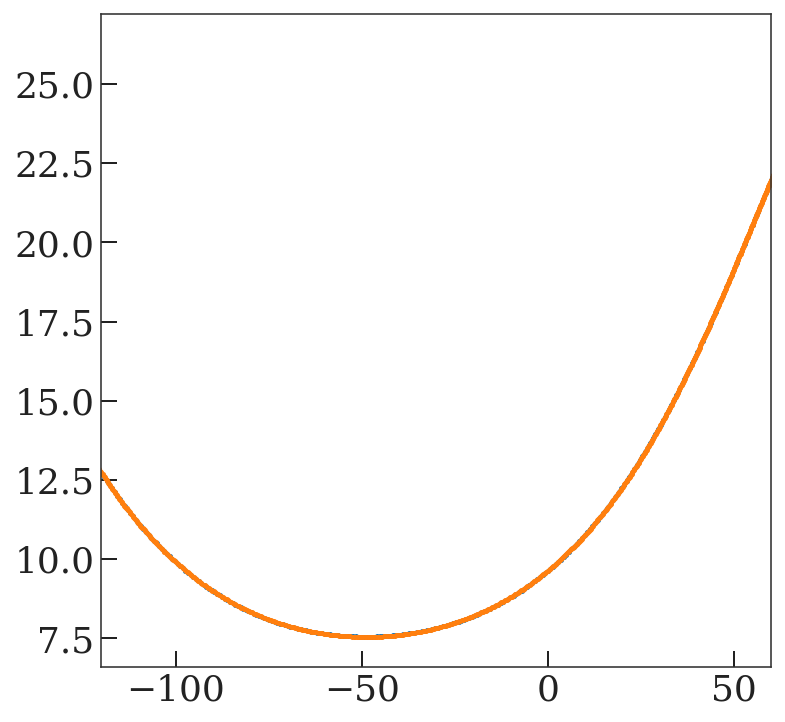

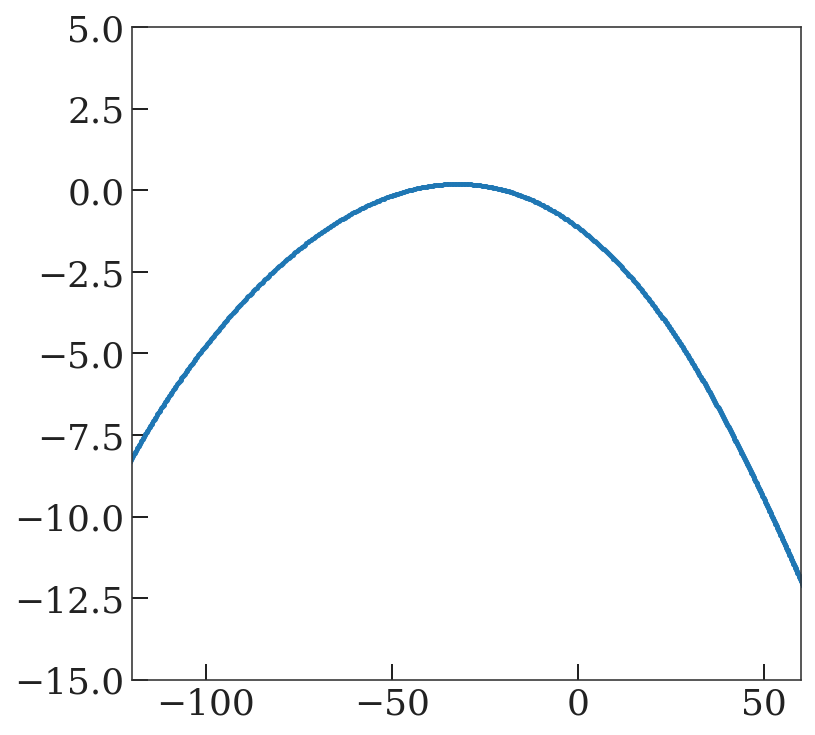

In [12]:
dist_coeffs = np.polyfit(orbit_gd1.phi1.wrap_at(180*u.deg).degree, 
                         orbit_gd1.distance.value, 
                         7)

grid = np.linspace(-120, 60, 256)
dist = np.polyval(dist_coeffs, grid)

plt.plot(grid, dist)
plt.plot(orbit_gd1.phi1.wrap_at(180*u.deg), 
         orbit_gd1.distance)
plt.xlim(-120, 60)

plt.figure()
plt.plot(orbit_gd1.phi1.wrap_at(180*u.deg), 
         orbit_gd1.phi2.degree)
plt.xlim(-120, 60)
plt.ylim(-15, 5)

(14.3, 15)

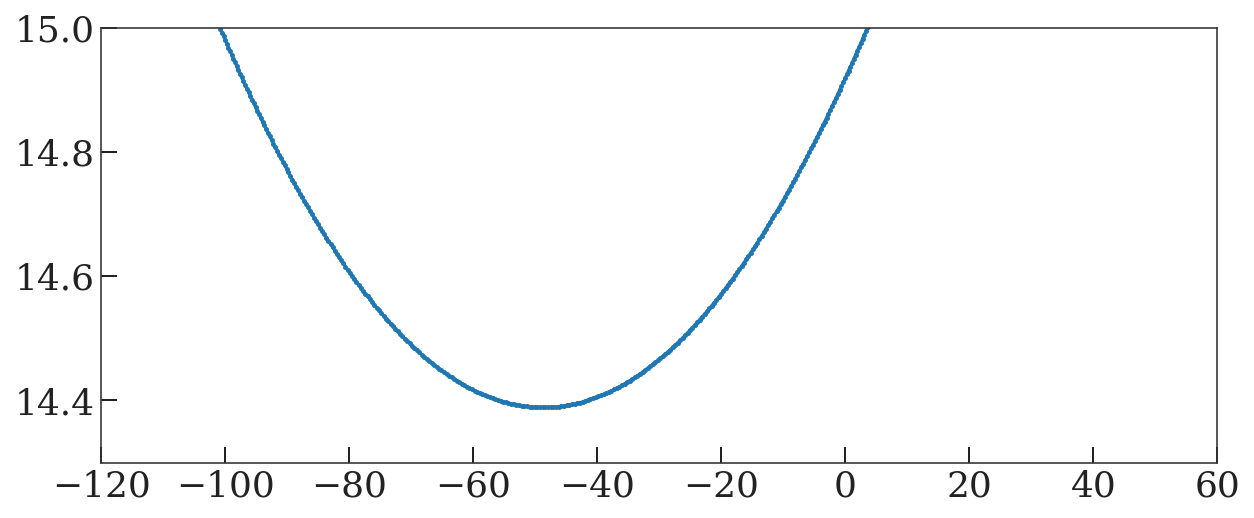

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(orbit_gd1.phi1.wrap_at(180*u.deg), 
         orbit_gd1.distance.distmod)
plt.xlim(-120, 60)
plt.ylim(14.3, 15)

In [14]:
def gd1_k10_dist(phi1):
    phi1 = coord.Angle(phi1)
    return coord.Distance(np.polyval(dist_coeffs, phi1.wrap_at(180*u.deg).degree) * u.kpc)

In [15]:
c_gd1 = c.transform_to(gc.GD1)
phi1 = c_gd1.phi1.wrap_at(180*u.deg)
est_dist = gd1_k10_dist(phi1)

c_dist = g.get_skycoord(distance=est_dist, radial_velocity=0*u.km/u.s)
c_gd1 = c_dist.transform_to(gc.GD1)
gd1 = gc.reflex_correct(c_gd1)

In [16]:
BP0 = g.get_BP0()
RP0 = g.get_RP0()
G0 = g.get_G0()

In [17]:
points_gi = np.array([g.g0 - g.i0, g.g0]).T
points_rz = np.array([g.r0 - g.z0, g.r0]).T
points_bprp = np.array([BP0 - RP0, G0]).T

In [18]:
gig_bins = (np.linspace(-1, 1, 64),
            np.linspace(15, 21, 128))

pm_bins = (np.linspace(-15, 5, 51),
           np.linspace(-10, 10, 51))

bin_size = 6
phi1_bins = np.arange(-100, 20+1e-3, bin_size) * u.deg
len(phi1_bins)

21

Initial CMD selection, used to refine PM selection:

In [19]:
plot = False

all_cmd_mask = np.zeros(len(g)).astype(bool)

if plot:
    fig, axes = plt.subplots(4, 5*2, figsize=(20, 10))

l_bins = phi1_bins[:-1]
r_bins = phi1_bins[1:]
for j, l, r in zip(range(len(l_bins)), l_bins, r_bins):
    phi1_mask = (phi1 >= l) & (phi1 <= r)
    DM = gd1_k10_dist(0.5 * (l+r)).distmod.value
    
    # main sequence + rgb mask
    # g-i vs g
    i_gi = iso['ps1_g']-iso['ps1_i']
    i_g = iso['ps1_g'] + DM
    gi_left = i_gi - 0.4*(i_g/28)**5
    gi_right = i_gi + 0.5*(i_g/28)**5
    
    # r-z vs r
    i_rz = iso['ps1_r']-iso['ps1_z']
    i_r = iso['ps1_r'] + DM
    rz_left = i_rz - 0.5*(i_r/28)**5
    rz_right = i_rz + 0.5*(i_r/28)**5

    poly = np.hstack([np.array([gi_left, i_g]), np.array([gi_right[::-1], i_g[::-1]])]).T
    ind = (poly[:,1] < 21.3) & (poly[:,1] > (3.25+DM))
    poly_main_gi = poly[ind]
    cmd_mask_gi = mpl.path.Path(poly_main_gi).contains_points(points_gi)
    
    poly = np.hstack([np.array([rz_left, i_r]), np.array([rz_right[::-1], i_r[::-1]])]).T
    ind = (poly[:,1]<21.3) & (poly[:,1]>(2.5+DM))
    poly_main_rz = poly[ind]
    cmd_mask_rz = mpl.path.Path(poly_main_rz).contains_points(points_rz)
    
    all_cmd_mask = all_cmd_mask | (phi1_mask & cmd_mask_gi & cmd_mask_rz)
    
    if plot:
        ax1 = axes.flat[2*j]
        ax2 = axes.flat[2*j+1]
    
    #     ax1.plot(points_gi[phi1_mask, 0], points_gi[phi1_mask, 1], 
    #              marker=',', alpha=0.25, ls='none', color='k')
        H, xe, ye = np.histogram2d(points_gi[phi1_mask, 0], 
                                   points_gi[phi1_mask, 1],
                                   bins=gig_bins)
        ax1.pcolormesh(xe, ye, H.T, 
                       norm=mpl.colors.LogNorm(), cmap='magma')

        pm = mpl.patches.Polygon(poly_main_gi, color='tab:green', alpha=0.25, 
                                 zorder=2, label='', linewidth=0)
        ax1.add_artist(pm)

        # --------------------------------
        # Proper motions for cmd-filtered:

        full_mask = cmd_mask_gi & cmd_mask_rz & phi1_mask
    #     ax2.plot(gd1.pm_phi1_cosphi2[full_mask].value,
    #              gd1.pm_phi2[full_mask].value,
    #              marker='.', alpha=0.4, ls='none', color='k')
        H, xe, ye = np.histogram2d(gd1.pm_phi1_cosphi2[full_mask].value,
                                   gd1.pm_phi2[full_mask].value,
                                   bins=pm_bins)
        ax2.pcolormesh(xe, ye, H.T, 
                       norm=mpl.colors.LogNorm(), cmap='viridis')

        # ------------------
        # Limits and labels:

        ax1.set_xlim(0, 1)
        ax1.set_ylim(21.5, 16)

        ax2.set_xlim(-15, 5)
        ax2.set_ylim(-10, 10)

        ax1.xaxis.set_visible(False)
        ax1.yaxis.set_visible(False)

        ax2.xaxis.set_visible(False)
        ax2.yaxis.set_visible(False)

In [20]:
all_cmd_mask.sum()

431084

In [21]:
# ctl_mask = (c_gd1.phi2 > 2*u.deg) | (c_gd1.phi2 < -5.5*u.deg)
# gd1_mask = (c_gd1.phi2 < 2*u.deg) & (c_gd1.phi2 > -5.5*u.deg)
_points = np.stack((phi1.value, c_gd1.phi2.value)).T
gd1_mask = gd1_phi_path.contains_points(_points)
ctl_mask = (ctl_phi_path[0].contains_points(_points) |
            ctl_phi_path[1].contains_points(_points))
ctl_mask.sum(), gd1_mask.sum()

(1864646, 1855970)

Now we use the initial CMD selection to validate this PM selection (using my orbit fit):

In [22]:
pm_bins = (np.arange(-15, 5+1e-3, 0.4),
           np.arange(-10, 10+1e-3, 0.4))

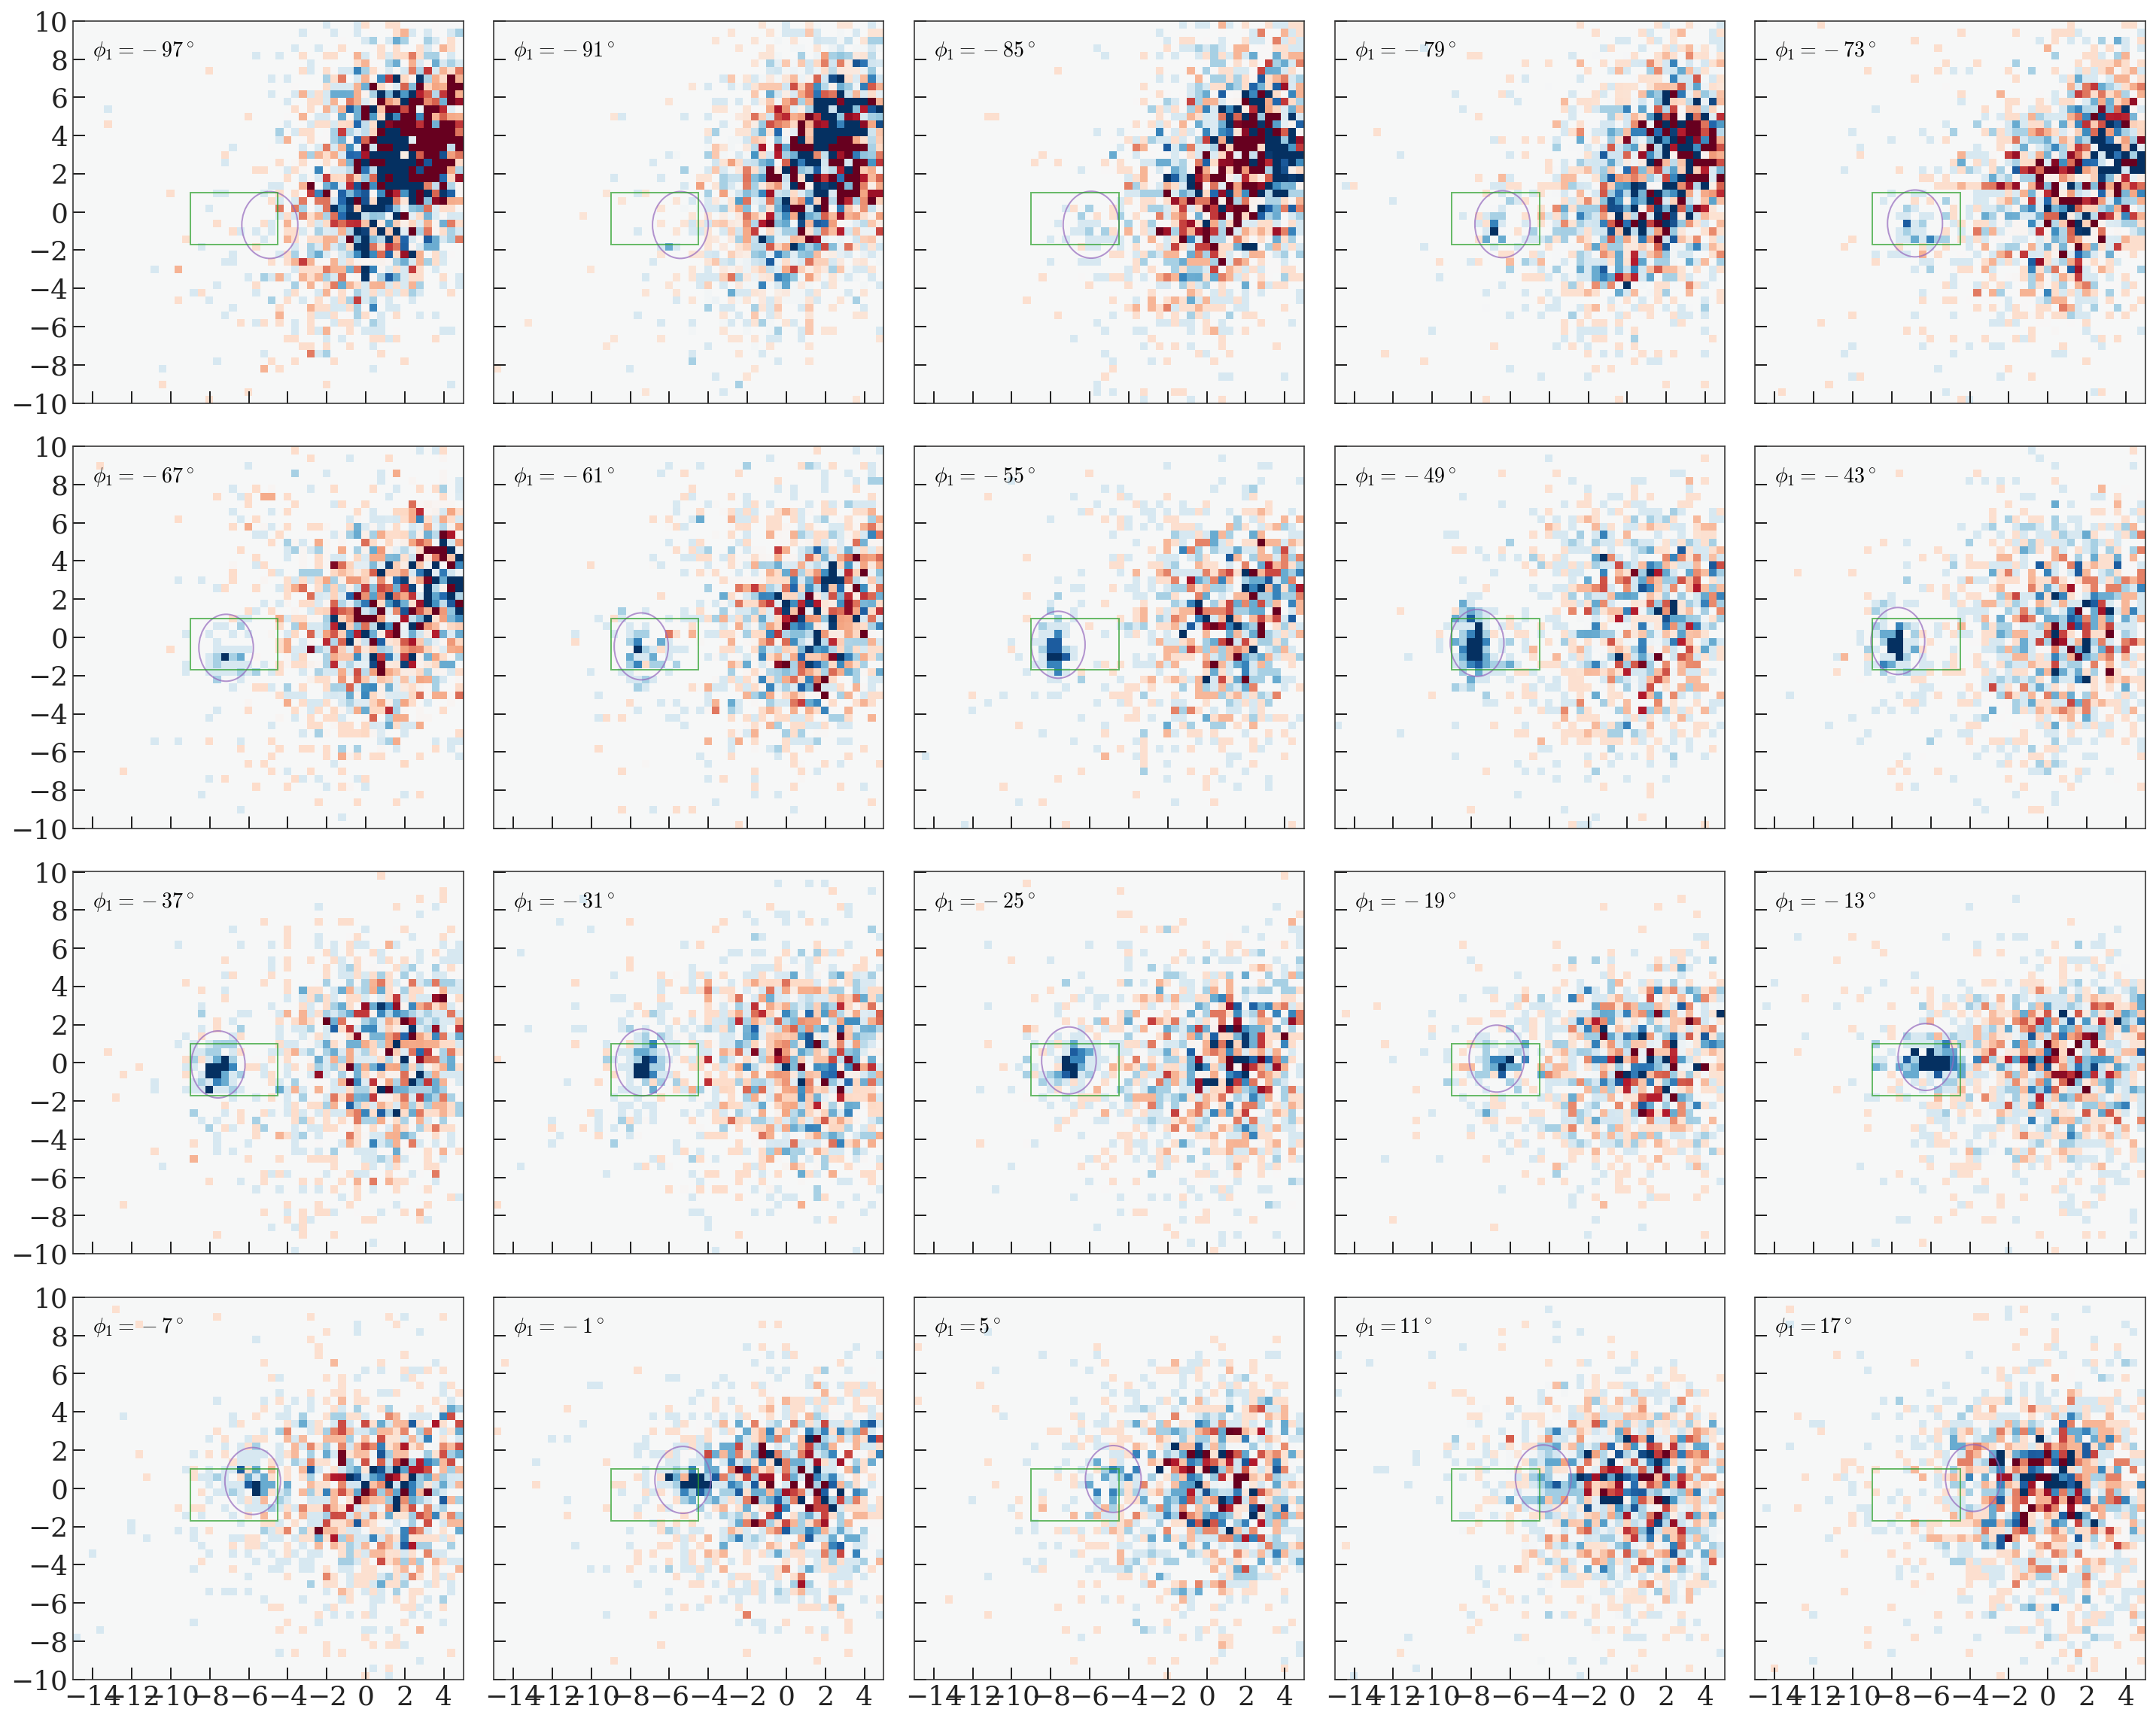

In [23]:
pm1 = gd1.pm_phi1_cosphi2.value
pm2 = gd1.pm_phi2.value
pmX = np.vstack((pm1, pm2)).T

fig, axes = plt.subplots(4, 5, figsize=(20, 16),
                         sharex=True, sharey=True)

pm_mask = np.zeros(len(g)).astype(bool)

l_bins = phi1_bins[:-1]
r_bins = phi1_bins[1:]
for j, l, r in zip(range(len(l_bins)), l_bins, r_bins):
    phi1_mask = (phi1 >= l) & (phi1 <= r)
    orbit_phi1_mask = (orbit_gd1.phi1.wrap_at(180*u.deg) >= l) & (orbit_gd1.phi1.wrap_at(180*u.deg) < r)
    ax = axes.flat[j]
    
    this_ctl_mask = all_cmd_mask & phi1_mask & ctl_mask
    this_gd1_mask = all_cmd_mask & phi1_mask & gd1_mask
    # print(this_ctl_mask.sum(), this_gd1_mask.sum())
    
    H_ctl, xe, ye = np.histogram2d(pm1[this_ctl_mask],
                                   pm2[this_ctl_mask],
                                   bins=pm_bins)
    
    H_gd1, xe, ye = np.histogram2d(pm1[this_gd1_mask],
                                   pm2[this_gd1_mask],
                                   bins=pm_bins)
    
    norm_mask = gd1.pm_phi1_cosphi2 > 0
    n_ctl = (norm_mask & this_ctl_mask).sum()
    n_gd1 = (norm_mask & this_gd1_mask).sum()
    H_ctl *= n_gd1 / n_ctl
    
    ax.pcolormesh(xe, ye, (H_gd1 - H_ctl).T,
                            cmap='RdBu', vmin=-6, vmax=6)
    med_phi1 = 0.5*(l+r)
    ax.text(-14, 9, r'$\phi_1 = {:.0f}^\circ$'.format(med_phi1.value), 
            va='top', fontsize=14)
    
    # over-plot orbit
    o_pm1 = orbit_gd1.pm_phi1_cosphi2[orbit_phi1_mask].value
    o_pm2 = orbit_gd1.pm_phi2[orbit_phi1_mask].value
    # ax.plot(o_pm1, o_pm2,
    #         color='k', marker='.')

    xy0 = (np.nanmedian(o_pm1), np.nanmedian(o_pm2))
    circ = mpl.patches.Ellipse(xy=xy0, 
                               width=5.5*np.sqrt(np.nanvar(o_pm1) + 0.5**2), 
                               height=7*np.sqrt(np.nanvar(o_pm2) + 0.5**2),
                               edgecolor='tab:purple', facecolor='none', 
                               zorder=10, alpha=0.7)
    ax.add_patch(circ)
    
    this_pm_mask = np.sqrt( (pm1 - xy0[0])**2/(circ.width/2)**2 + 
                            (pm2 - xy0[1])**2/(circ.height/2)**2) < 1.
    pm_mask = pm_mask | (phi1_mask & this_pm_mask)
    
    r = mpl.patches.Rectangle((-9., -1.7), 4.5, 2.7, 
                              edgecolor='tab:green', facecolor='none', 
                              zorder=10, alpha=0.7)
    ax.add_patch(r)
    
    ax.xaxis.set_ticks(np.arange(-14, 4+1e-3, 2))
    ax.yaxis.set_ticks(np.arange(-10, 10+1e-3, 2))

for k in range(j+1, len(axes.flat)):
    axes.flat[k].set_visible(False)
    
fig.tight_layout()

In [24]:
gig_bins2 = (np.linspace(-1, 1, 64),
             np.linspace(15, 21, 64))

bin_size2 = 10
phi1_bins2 = np.arange(-100, 20+1e-3, bin_size2) * u.deg
len(phi1_bins2) - 1

12

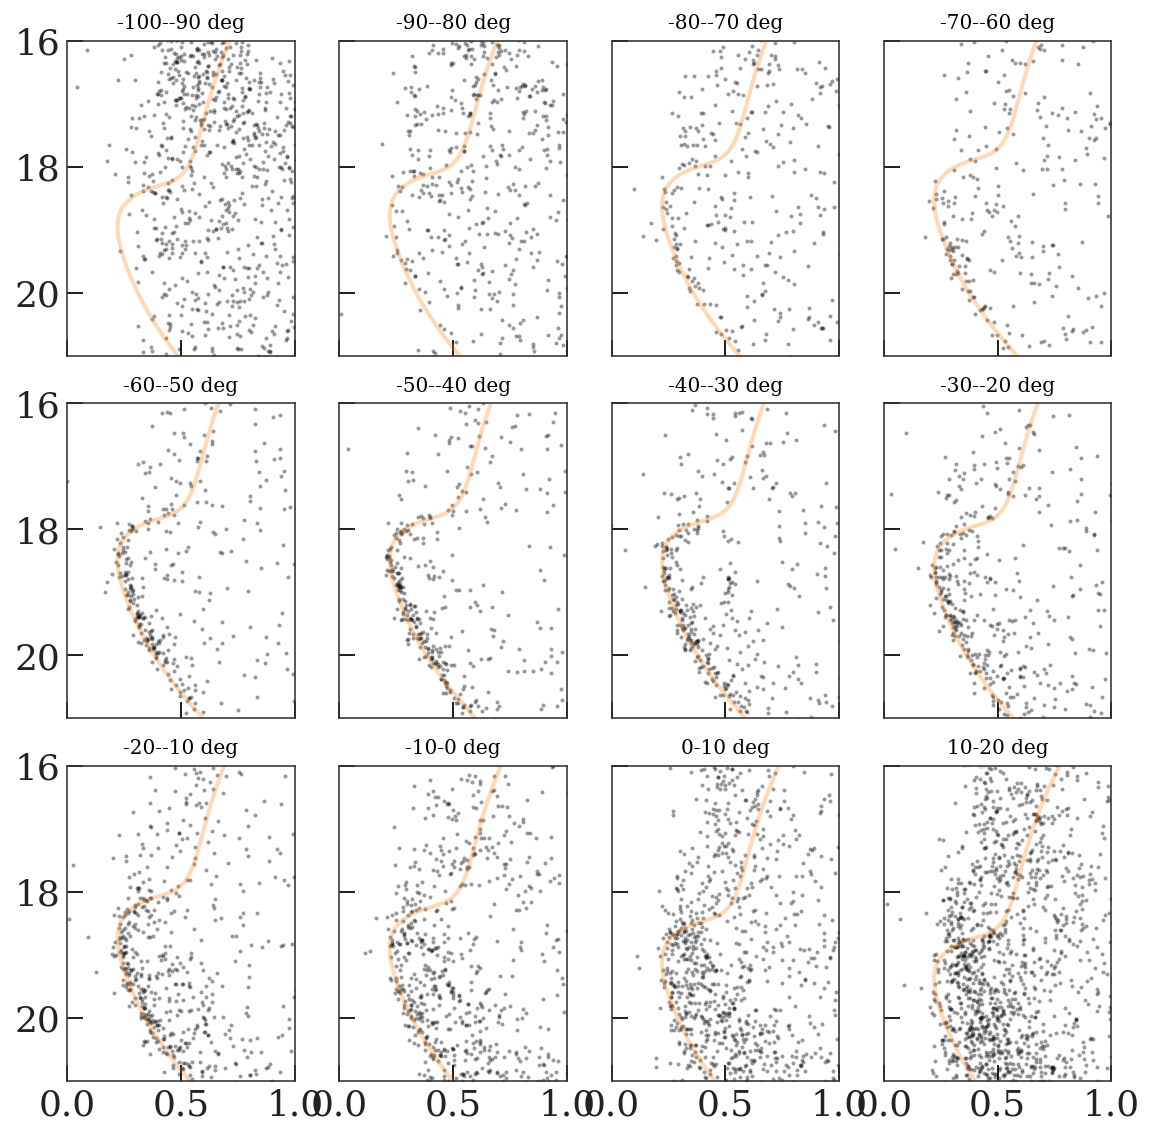

In [25]:
plot = True

if plot:
    fig, axes = plt.subplots(3, 4, figsize=(8, 8),
                             sharex=True, sharey=True)
    
l_bins = phi1_bins2[:-1]
r_bins = phi1_bins2[1:]

DM_shifts = np.zeros(len(l_bins))
# DM_shifts[4] += 0.1
# DM_shifts[5] += 0.15
# DM_shifts[6] += 0.2

for j, l, r, dm_shift in zip(range(len(l_bins)), l_bins, r_bins, DM_shifts):
    ax = axes.flat[j]
    phi1_mask = (phi1 >= l) & (phi1 <= r)
    DM = gd1_k10_dist(0.5 * (l+r)).distmod.value + dm_shift
    
    this_ctl_mask = pm_mask & phi1_mask & ctl_mask
    this_gd1_mask = pm_mask & phi1_mask & gd1_mask
    
    H_ctl, xe, ye = np.histogram2d(points_gi[this_ctl_mask, 0],
                                   points_gi[this_ctl_mask, 1],
                                   bins=gig_bins2)
    
    H_gd1, xe, ye = np.histogram2d(points_gi[this_gd1_mask, 0],
                                   points_gi[this_gd1_mask, 1],
                                   bins=gig_bins2)
    
    norm_mask = (gd1.pm_phi1_cosphi2 > 0) & phi1_mask
    n_ctl = (norm_mask & ctl_mask).sum()
    n_gd1 = (norm_mask & gd1_mask).sum()
    H_ctl *= n_gd1 / n_ctl
    
    if plot:
#         ax.pcolormesh(xe, ye, (H_gd1 - H_ctl).T,
#                       cmap='RdBu', vmin=-3, vmax=3)
        ax.plot(points_gi[this_gd1_mask, 0],
                points_gi[this_gd1_mask, 1],
                marker='o', ls='none',
                ms=2., color='k', alpha=0.4)

        ax.plot(iso['ps1_g']-iso['ps1_i'],
                iso['ps1_g'] + DM, 
                marker='', alpha=0.3, 
                color='tab:orange', lw=2)
        
        ax.set_title('{0:.0f}-{1:.0f} deg'.format(l.value, r.value), fontsize=10)
        

if plot:
    ax.set_xlim(0, 1)
    ax.set_ylim(21., 16)
    
fig.tight_layout()

### Same plot in Gaia photometry

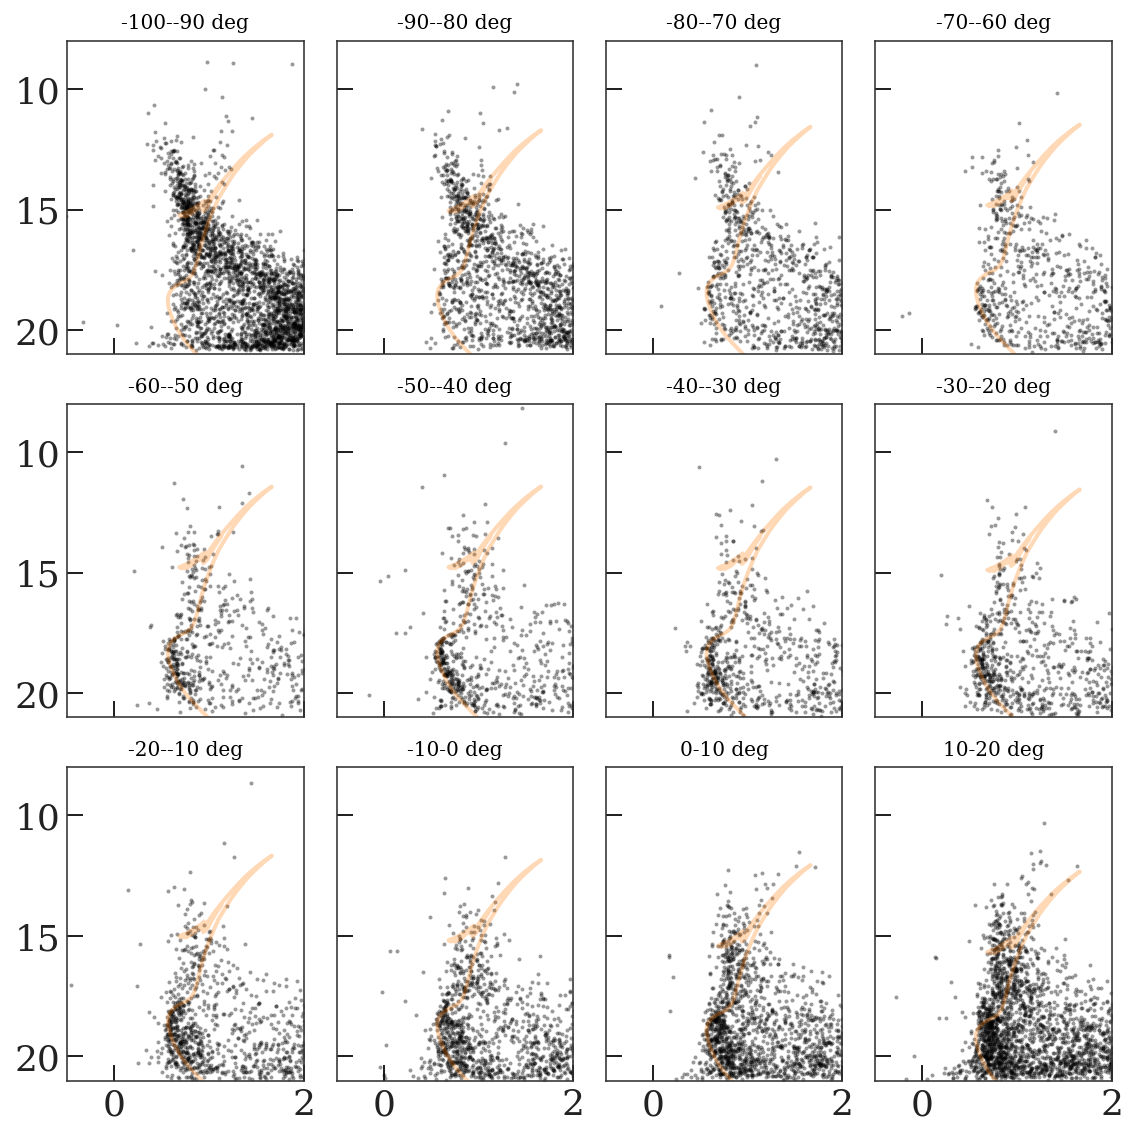

In [26]:
fig, axes = plt.subplots(3, 4, figsize=(8, 8),
                         sharex=True, sharey=True)

l_bins = phi1_bins2[:-1]
r_bins = phi1_bins2[1:]
for j, l, r in zip(range(len(l_bins)), l_bins, r_bins):
    ax = axes.flat[j]
    phi1_mask = (phi1 >= l) & (phi1 <= r)
    DM = gd1_k10_dist(0.5 * (l+r)).distmod.value
    
    this_ctl_mask = pm_mask & phi1_mask & ctl_mask
    this_gd1_mask = pm_mask & phi1_mask & gd1_mask
    
    
    ax.plot(points_bprp[this_gd1_mask, 0],
            points_bprp[this_gd1_mask, 1],
            marker='o', ls='none',
            ms=2., color='k', alpha=0.4)

    ax.plot(iso['G_BP']-iso['G_RP'],
            iso['G'] + DM, 
            marker='', alpha=0.3, 
            color='tab:orange', lw=2)

    ax.set_title('{0:.0f}-{1:.0f} deg'.format(l.value, r.value), fontsize=10)
        

ax.set_xlim(-0.5, 2)
ax.set_ylim(21., 8)
    
fig.tight_layout()

In [27]:
# plt.plot(iso['ps1_g'] - iso['ps1_i'],
#          iso['ps1_g'] - iso['G'])

# plt.plot(iso['ps1_g'] - iso['ps1_i'],
#          iso['ps1_i'] - iso['G'])

# plt.xlabel('$g-i$')
# plt.ylabel('$g-G$, $i-G$')

# plt.xlim(0, 1)
# plt.ylim(-1., 1.)

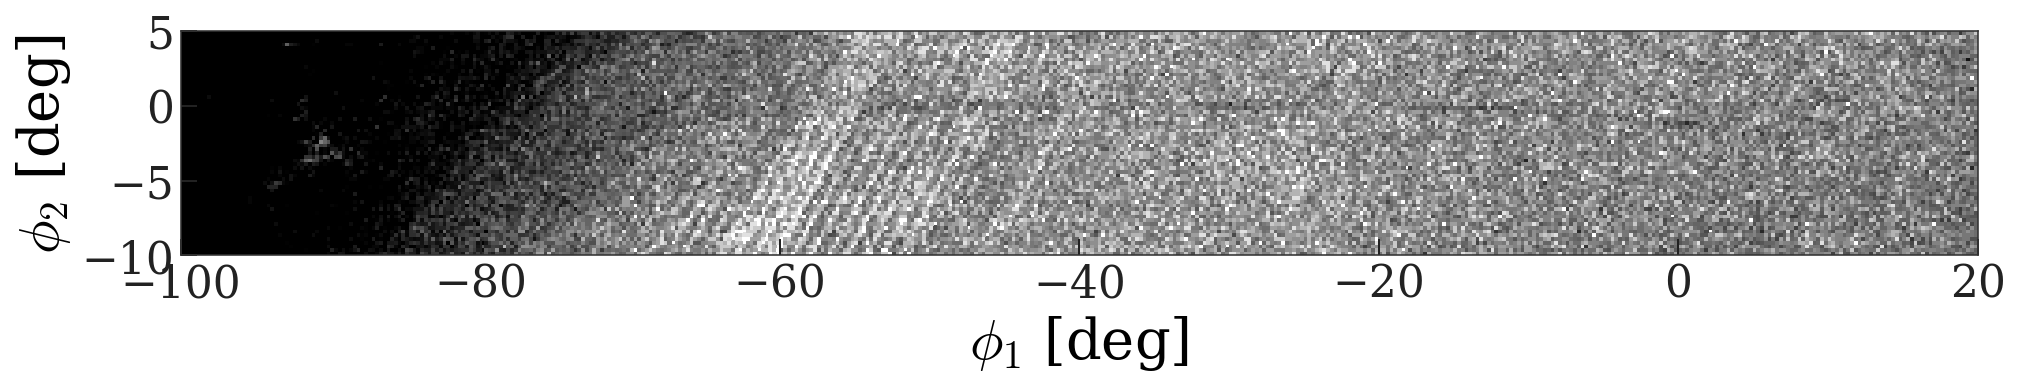

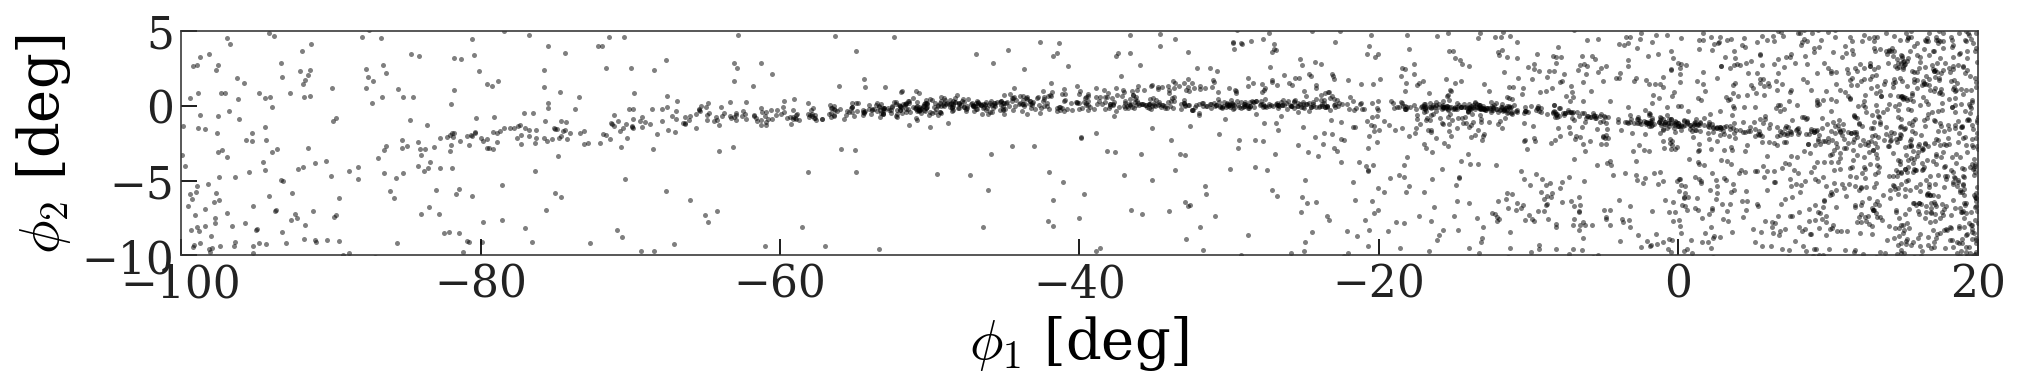

In [28]:
for i, stream_mask in enumerate([all_cmd_mask, 
                                 all_cmd_mask & pm_mask]):
    fig, ax = plt.subplots(1, 1, figsize=(14, 2.75))
    
    if i == 0:
        H, xe, ye = np.histogram2d(c_gd1.phi1.wrap_at(180*u.deg).degree[stream_mask],
                                   c_gd1.phi2.degree[stream_mask], 
                                   bins=(np.arange(-100, 20+1e-3, 0.25),
                                         np.arange(-10, 5+1e-3, 0.25)))
        ax.pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(vmin=1e0, vmax=3e1))

    else:
        ax.plot(c_gd1.phi1.wrap_at(180*u.deg).degree[stream_mask],
                c_gd1.phi2.degree[stream_mask], 
                marker='.', linestyle='none', alpha=0.5, c='k')

    ax.set_xlim(-100, 20)
    ax.set_ylim(-10, 5)
    
    ax.xaxis.set_ticks(np.arange(-100, 20+1e-3, 20))
    ax.yaxis.set_ticks(np.arange(-10, 5+1e-3, 5))
    
    ax.set_xlabel(r'$\phi_1$ [deg]', fontsize=28)
    ax.set_ylabel(r'$\phi_2$ [deg]', fontsize=28)

    fig.tight_layout()
    ax.set_aspect('equal')
    
    fig.set_facecolor('w')
    
    ax.xaxis.set_tick_params(labelsize=22)
    ax.yaxis.set_tick_params(labelsize=22)
    
    # ax.scatter(gd1_track[:, 0], gd1_track[:, 1]-1.5, color='tab:red')
    # ax.scatter(gd1_track[:, 0], gd1_track[:, 1]+1.5, color='tab:red')
    
#     fig.savefig('../plots/better-selection-{0}.png'.format(i), dpi=250)

In [31]:
g.data['sliding_gi_cmd_mask'] = all_cmd_mask
g.data['sliding_pm_mask'] = pm_mask
g.data[g.phi2 > -10].write('../data/gd1-better-selection.fits')

---

### Now look at the distance-shifted, stacked CMD to improve isochrone selection:

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


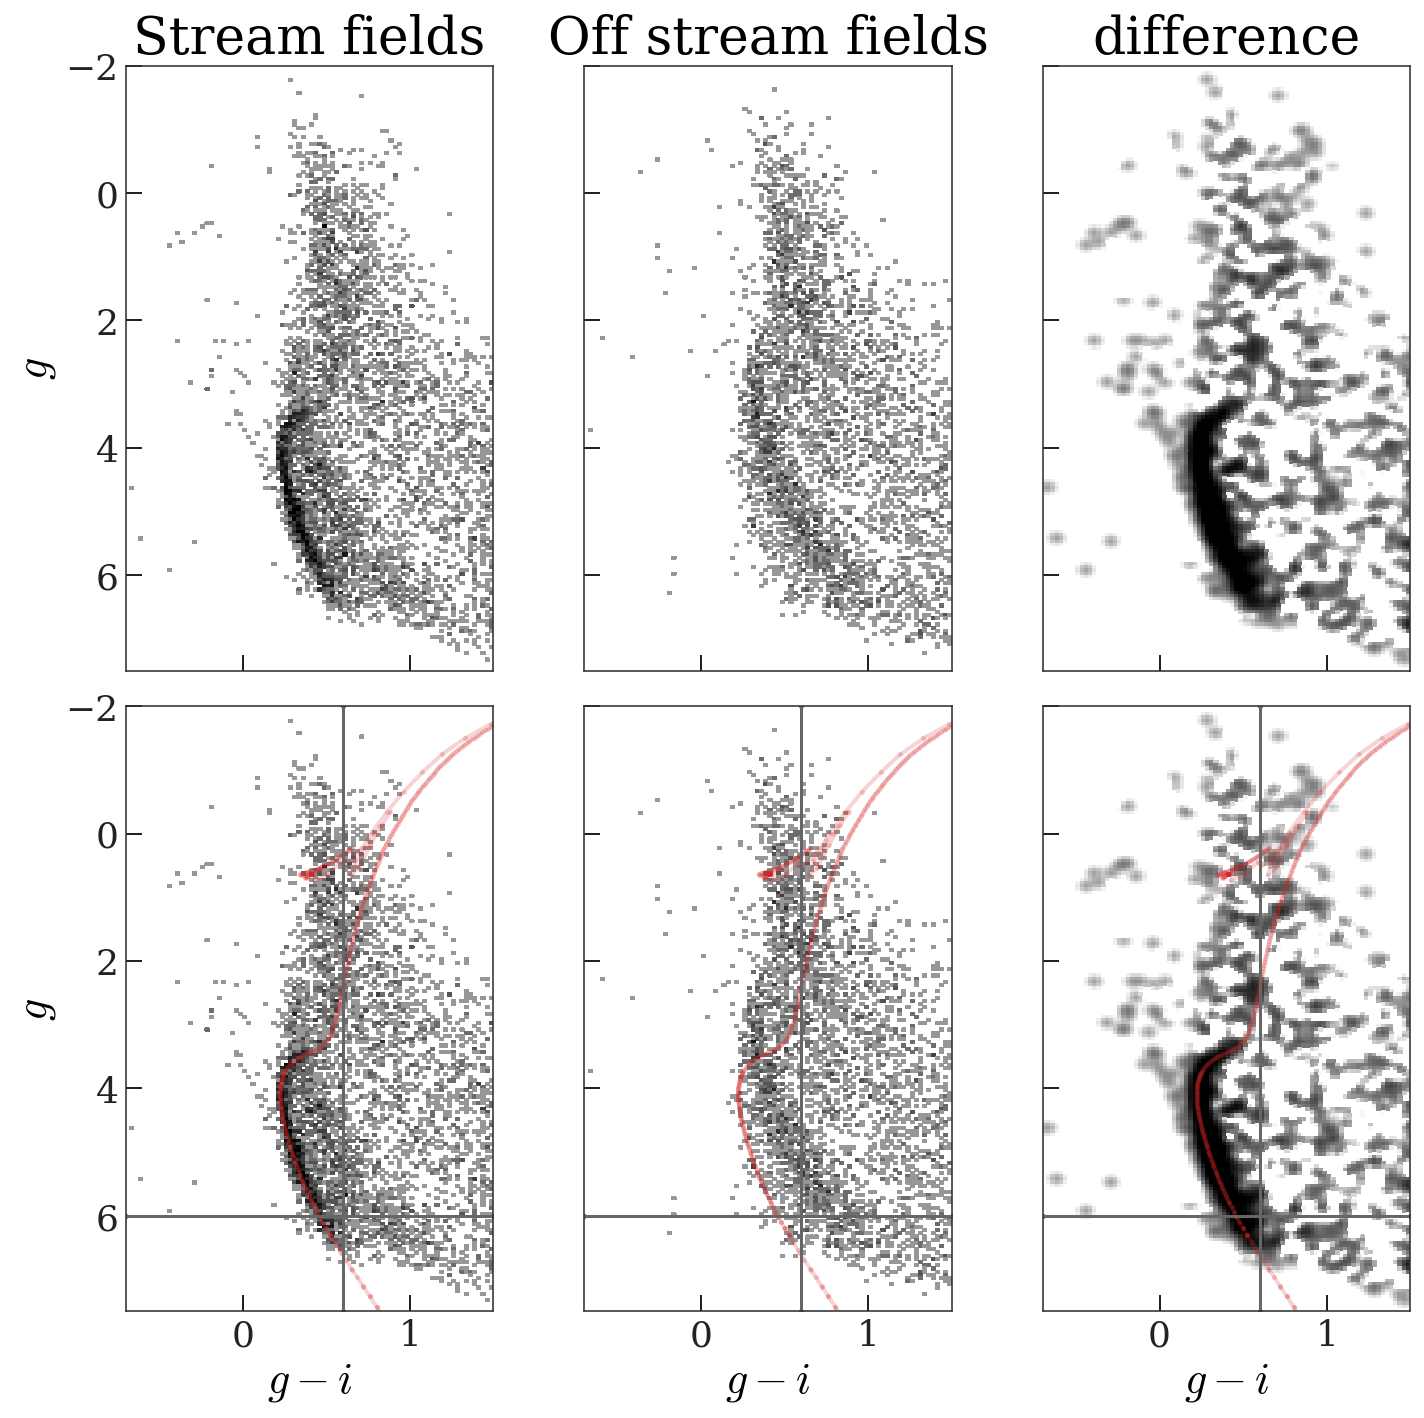

In [59]:
DMs = est_dist.distmod.value

fig, axes = plt.subplots(2, 3, figsize=(10, 10), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

bins = (np.arange(-0.7, 1.5+1e-3, 0.025),
        np.arange(-5, 10+1e-3, 0.05))

_mask = gd1_mask & pm_mask & (phi1 > -85*u.deg) & (phi1 < 5*u.deg)
H1, xe, ye = np.histogram2d(points_gi[_mask, 0], 
                            points_gi[_mask, 1] - DMs[_mask],
                            bins=bins)

_mask = ctl_mask & pm_mask & (phi1 > -85*u.deg) & (phi1 < 5*u.deg)
H2, xe, ye = np.histogram2d(points_gi[_mask, 0], 
                            points_gi[_mask, 1] - DMs[_mask],
                            bins=bins)

H1_sm = gaussian_filter(H1, 1.2)
H2_sm = gaussian_filter(H2, 1.2)

for ax in axes[:, 0]:
    ax.pcolormesh(xe, ye, H1.T, cmap='Greys', 
                  norm=mpl.colors.LogNorm(vmin=1e-1, vmax=10))
    ax.set_ylabel('$g$')
    
for ax in axes[:, 1]:
    ax.pcolormesh(xe, ye, H2.T, cmap='Greys', 
                  norm=mpl.colors.LogNorm(vmin=1e-1, vmax=10))
    
for ax in axes[:, 2]:
#     ax.pcolormesh(xe, ye, (H1 - H2).T, cmap='Greys', 
#                   norm=mpl.colors.LogNorm(vmin=1e-1, vmax=10))
    ax.pcolormesh(xe, ye, (H1_sm - H2_sm).T, cmap='Greys',
                  norm=mpl.colors.LogNorm(vmin=1e-2, vmax=2))

axes[0, 0].set_title('Stream fields')
axes[0, 1].set_title('Off stream fields')
axes[0, 2].set_title('difference')
    
for i in range(3):
    axes[1, i].set_xlabel('$g - i$')
    
for ax in axes[1]:
    ax.plot(iso['ps1_g'] - iso['ps1_i'],
            iso['ps1_g'], 
            color='tab:red', alpha=0.2, lw=2)
    
    # main sequence + rgb mask
    # g-i vs g
    i_gi = iso['ps1_g']-iso['ps1_i']
    i_g = iso['ps1_g'] + 15.
    gi_left = i_gi - 0.4*(i_g/28)**5
    gi_right = i_gi + 0.5*(i_g/28)**5

    poly = np.hstack([np.array([gi_left, i_g]), np.array([gi_right[::-1], i_g[::-1]])]).T
    ind = (poly[:,1] < 21.3) & (poly[:,1] > (3.25+15))
    poly_main_gi = poly[ind]
    poly_main_gi[:, 1] = poly_main_gi[:, 1] - 15
    poly = mpl.patches.Polygon(poly_main_gi, facecolor='tab:green',
                               linewidth=0, alpha=0.2)
    # ax.add_patch(poly)

ax.set_xlim(-0.7, 1.5)
ax.set_ylim(7.5, -2)

for ax in axes[1]:
    ax.axvline(0.6)
    ax.axhline(6)

fig.tight_layout()
# fig.savefig('../plots/shifted-cmd.png', dpi=250)

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


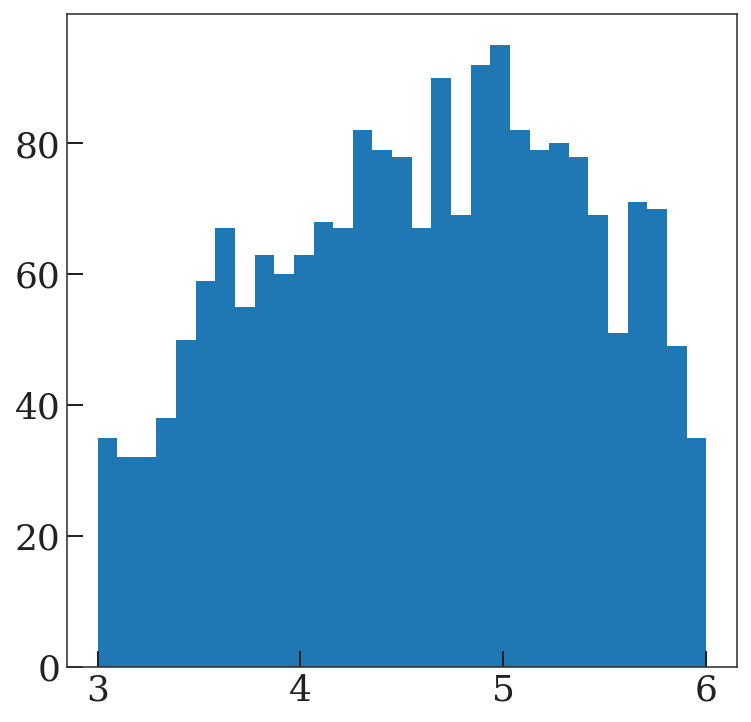

In [65]:
_mask = gd1_mask & pm_mask & (phi1 > -85*u.deg) & (phi1 < 5*u.deg)
_gis = points_gi[_mask, 0]
_gs = points_gi[_mask, 1] - DMs[_mask]
_mass_mask = ((_gis < 0.6) & (_gis > 0.1) &
              (_gs < 6) & (_gs > 3))
plt.hist(_gs[_mass_mask], bins=np.linspace(3, 6, 32));

In [66]:
_mass_mask = ((_gis < 0.6) & (_gis > 0.1) &
              (_gs < 5) & (_gs > 4))
46 * _mass_mask.sum()

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


36478

In [34]:
from scipy.ndimage import gaussian_filter

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


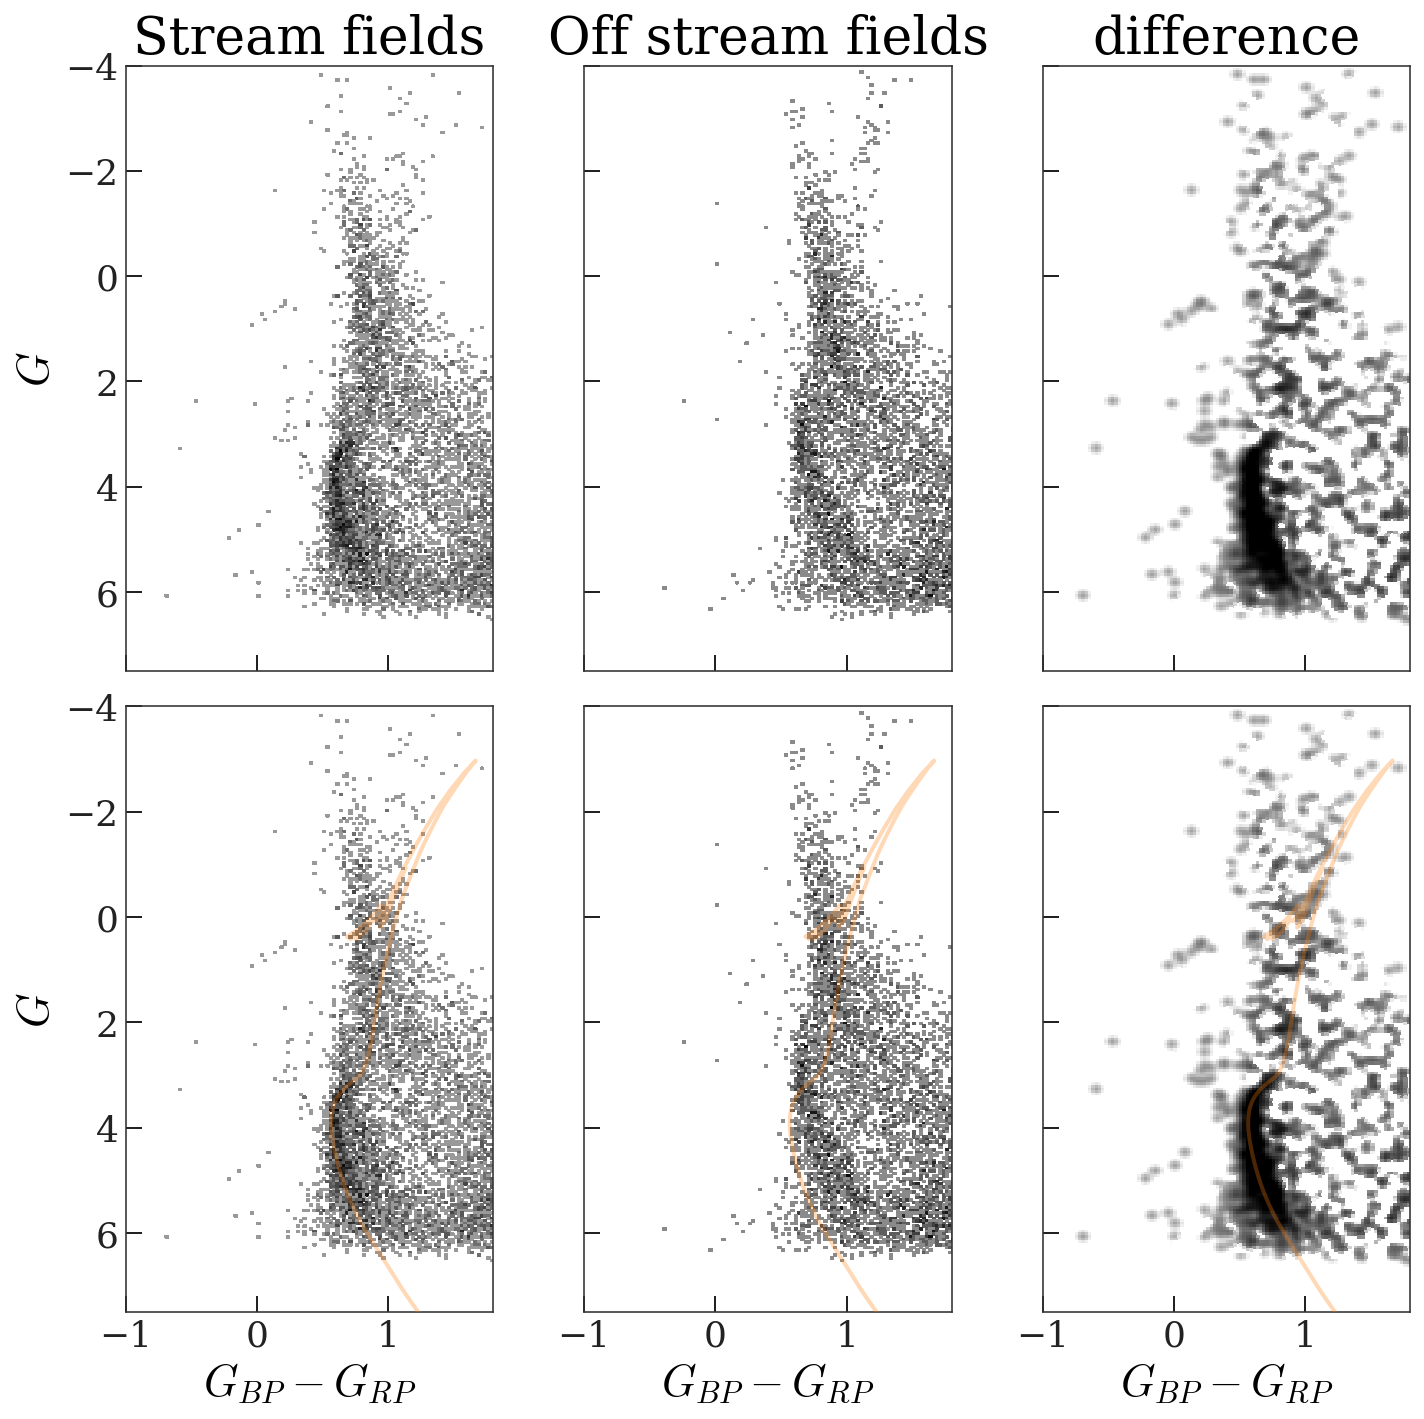

In [98]:
DMs = est_dist.distmod.value

fig, axes = plt.subplots(2, 3, figsize=(10, 10), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

bins = (np.arange(-1, 2.2+1e-3, 0.025),
        np.arange(-5, 10+1e-3, 0.05))

_mask = gd1_mask & pm_mask & (phi1 > -85*u.deg) & (phi1 < 5*u.deg)
H1, xe, ye = np.histogram2d(points_bprp[_mask, 0], 
                            points_bprp[_mask, 1] - DMs[_mask],
                            bins=bins)

_mask = ctl_mask & pm_mask & (phi1 > -85*u.deg) & (phi1 < 5*u.deg)
H2, xe, ye = np.histogram2d(points_bprp[_mask, 0], 
                            points_bprp[_mask, 1] - DMs[_mask],
                            bins=bins)

H1_sm = gaussian_filter(H1, 1.2)
H2_sm = gaussian_filter(H2, 1.2)

for ax in axes[:, 0]:
    ax.pcolormesh(xe, ye, H1.T, cmap='Greys', 
                  norm=mpl.colors.LogNorm(vmin=0.1))
    ax.set_ylabel('$G$')
    
for ax in axes[:, 1]:
    ax.pcolormesh(xe, ye, H2.T, cmap='Greys', 
                  norm=mpl.colors.LogNorm(vmin=0.1))
    
for ax in axes[:, 2]:
    # ax.pcolormesh(xe, ye, np.sqrt((H1_sm - H2_sm).T), cmap='Greys',
    #               vmin=0, vmax=1)
    ax.pcolormesh(xe, ye, (H1_sm - H2_sm).T, cmap='Greys',
                  norm=mpl.colors.LogNorm(vmin=1e-2, vmax=2))

axes[0, 0].set_title('Stream fields')
axes[0, 1].set_title('Off stream fields')
axes[0, 2].set_title('difference')
    
for i in range(3):
    axes[1, i].set_xlabel('$G_{BP} - G_{RP}$')
    
for ax in axes[1]:
    ax.plot(iso['G_BP'] - iso['G_RP'],
            iso['G'], 
            color='tab:orange', alpha=0.3, 
            lw=2, marker='', zorder=100)
    
ax.set_xlim(-1, 1.8)
ax.set_ylim(7.5, -4)

fig.tight_layout()
# fig.savefig('../plots/shifted-cmd.png', dpi=250)

## Compare to M15

In [110]:
m15_cl_c = coord.SkyCoord.from_name('NGC 5272')

In [111]:
m15_g = GaiaData('../../gaia-scratch/data/ngc_5272.fits')
m15_c = m15_g.get_skycoord(distance=False)

In [112]:
cl_mask = (m15_c.separation(m15_cl_c) < 0.2*u.deg) & (m15_g.phot_g_mean_mag < 19*u.mag)

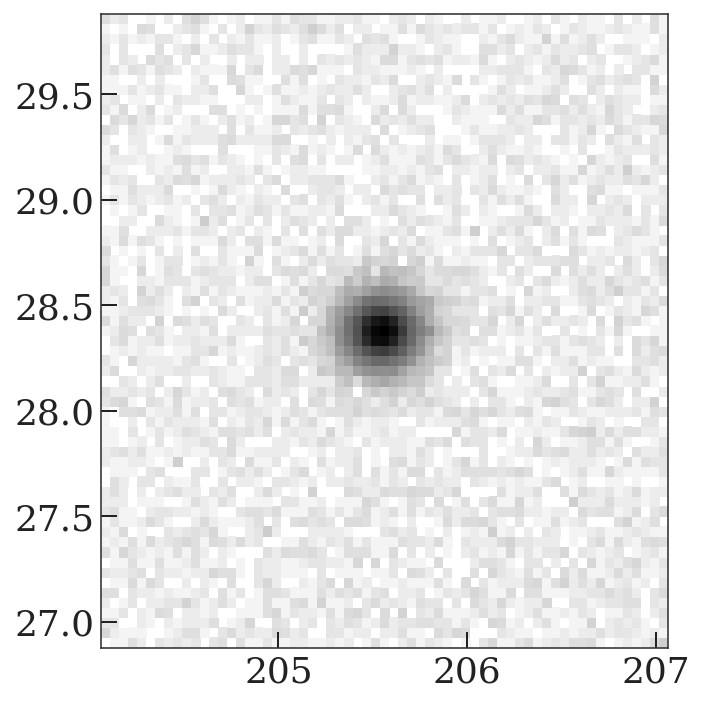

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist2d(m15_g.ra, m15_g.dec, 
          bins=(np.linspace(m15_g.ra.min(), m15_g.ra.max(), 64),
                np.linspace(m15_g.dec.min(), m15_g.dec.max(), 64)),
          norm=mpl.colors.LogNorm(),
          cmap='Greys')
fig.tight_layout()

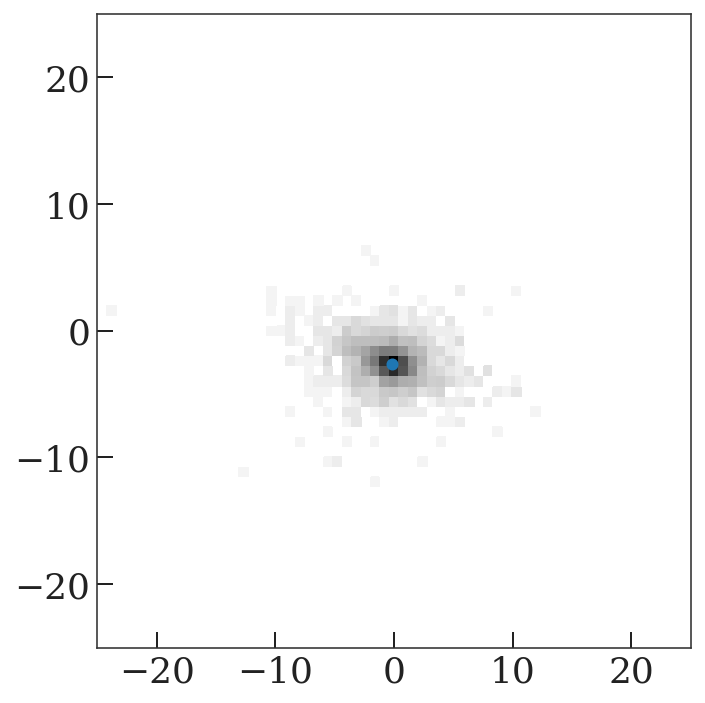

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist2d(m15_g.pmra[cl_mask], m15_g.pmdec[cl_mask], 
          bins=np.linspace(-25, 25, 64),
          norm=mpl.colors.LogNorm(),
          cmap='Greys')

mean_pmra = m15_g.pmra[cl_mask].mean()
mean_pmdec = m15_g.pmdec[cl_mask].mean()
ax.scatter(mean_pmra, mean_pmdec)

fig.tight_layout()

In [115]:
cl_mask = ((m15_c.separation(m15_cl_c) < 0.25*u.deg) & 
           (np.sqrt((m15_g.pmra - mean_pmra)**2 + (m15_g.pmdec - mean_pmdec)**2) < 1.5*u.mas/u.yr))
cl_mask.sum()

12918

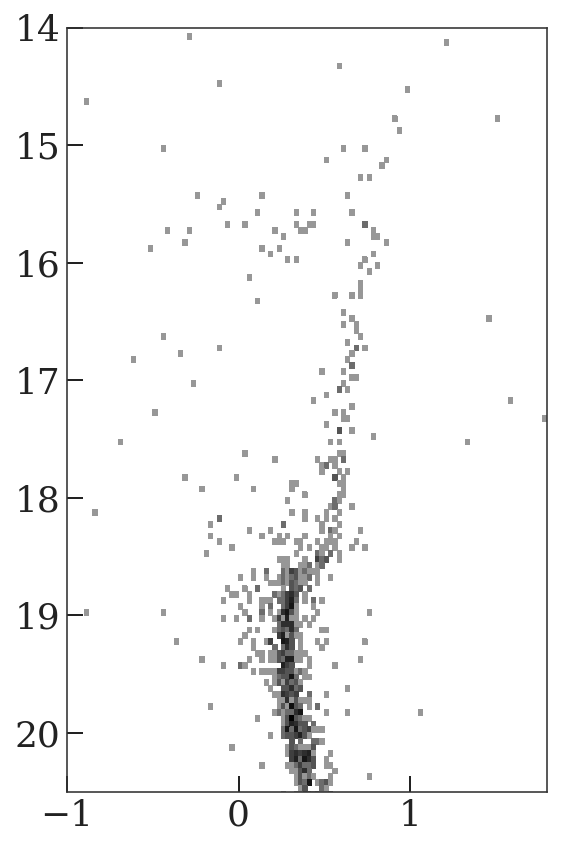

In [117]:
bins = (np.arange(-1, 2.2+1e-3, 0.025),
        np.arange(14, 21+1e-3, 0.05))

fig, ax = plt.subplots(1, 1, figsize=(4, 6))

_gi = (m15_g.g0 - m15_g.i0)[cl_mask][::10]
_g = m15_g.g0[cl_mask][::10]
H, xe, ye = np.histogram2d(_gi, _g, bins=bins)

ax.pcolormesh(xe, ye, H.T, cmap='Greys', 
              norm=mpl.colors.LogNorm(vmin=0.1))
# ax.set_ylabel('$G$')
    
ax.set_xlim(-1, 1.8)
ax.set_ylim(20.5, 14)

fig.tight_layout()